In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("complete")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-abstracts/covid_abstracts.csv
complete


In [2]:
import pandas as pd
import concurrent.futures
from tqdm import tqdm
#Import libraries:
import spacy
import pandas as pd
import requests
from spacy import displacy
# import en_core_web_sm
 
nlp = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
#import neptune.new as neptune
 
%matplotlib inline
print("complete")

complete


In [3]:
data = pd.read_csv("../input/covid-abstracts/covid_abstracts.csv")
print("complete")

complete


In [4]:
#Entity extraction
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]
print("complete")

complete


In [5]:
#pair the entities
pairs_of_entities = []
for i in tqdm(data['abstract'][:800]):
   pairs_of_entities.append(extract_entities(i))
print("complete")

100%|██████████| 800/800 [00:36<00:00, 21.73it/s]

complete


In [6]:
#Relations extraction
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]
  
   matcher.add("matching_1", None, pattern)
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return (span.text)
print("complete")

complete


In [7]:
relations = [obtain_relation(j) for j in tqdm(data['abstract'][:800])]
print("complete")

100%|██████████| 800/800 [00:33<00:00, 24.23it/s]

complete


In [8]:
#Let’s build a knowledge graph
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
print("complete")

complete


In [9]:
#We are using the networkx library to create a network from the data 
#frame.
#Here nodes will be represented as entities and edges represent 
#the relationship between nodes

# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())
print("complete")

complete


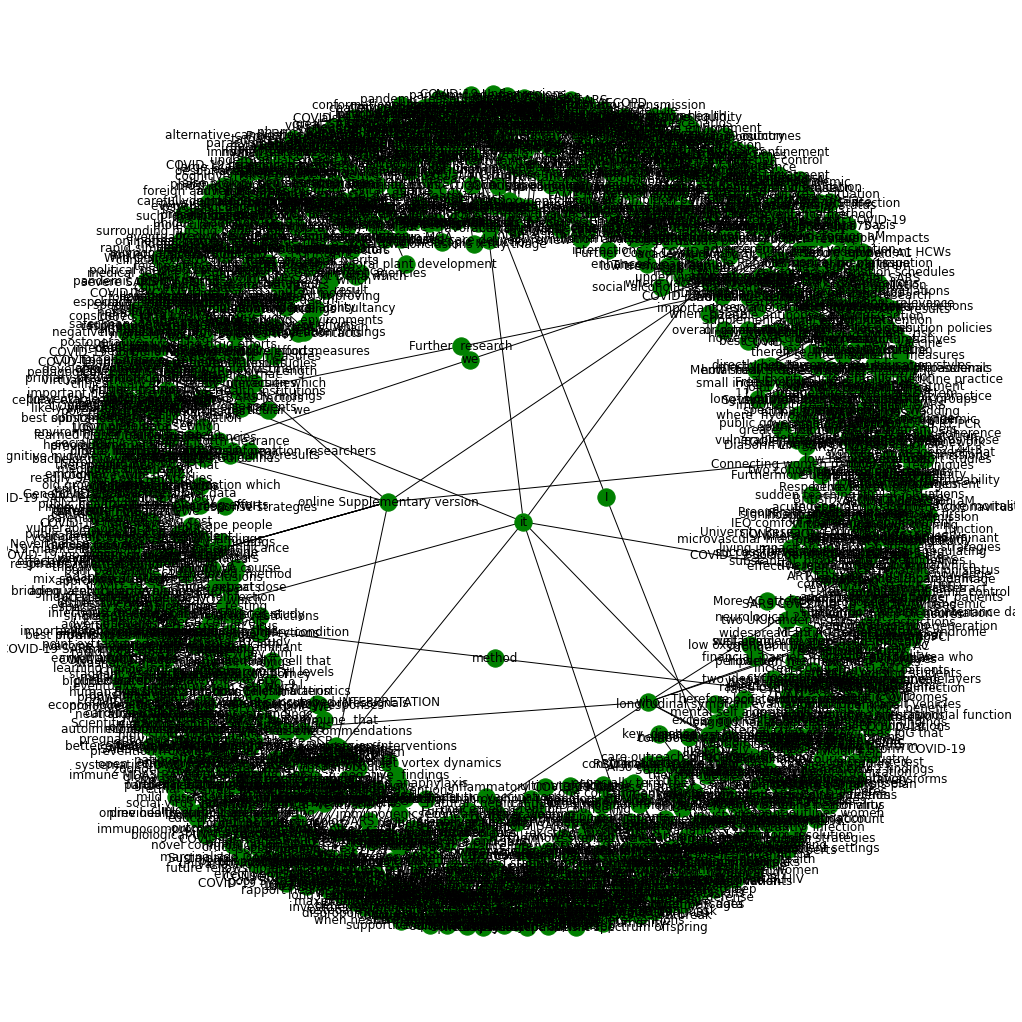

In [10]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [11]:
data_kgf['edge'][:10]

0    limited by small
1            supports
2                  is
3                  is
4                 was
5            fall out
6            indicate
7                help
8            conclude
9        demonstrated
Name: edge, dtype: object

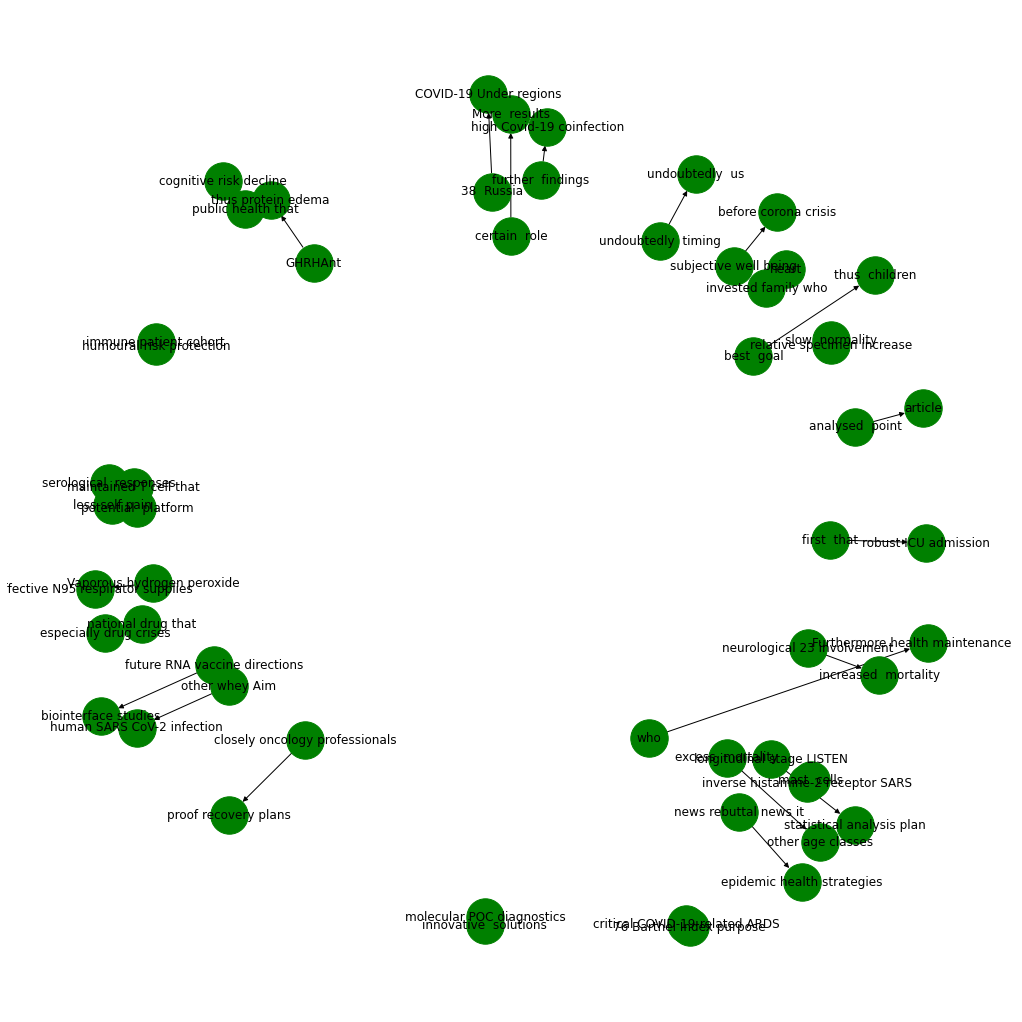

In [12]:
#One more graph filtered with the relation name “is”
#From the above graph it’s unclear to get a sense of what 
#relations are captured in the graph
#Let’s use some relation to visualize graphs. Here I am choosing:

graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="is"], "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())
 
plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

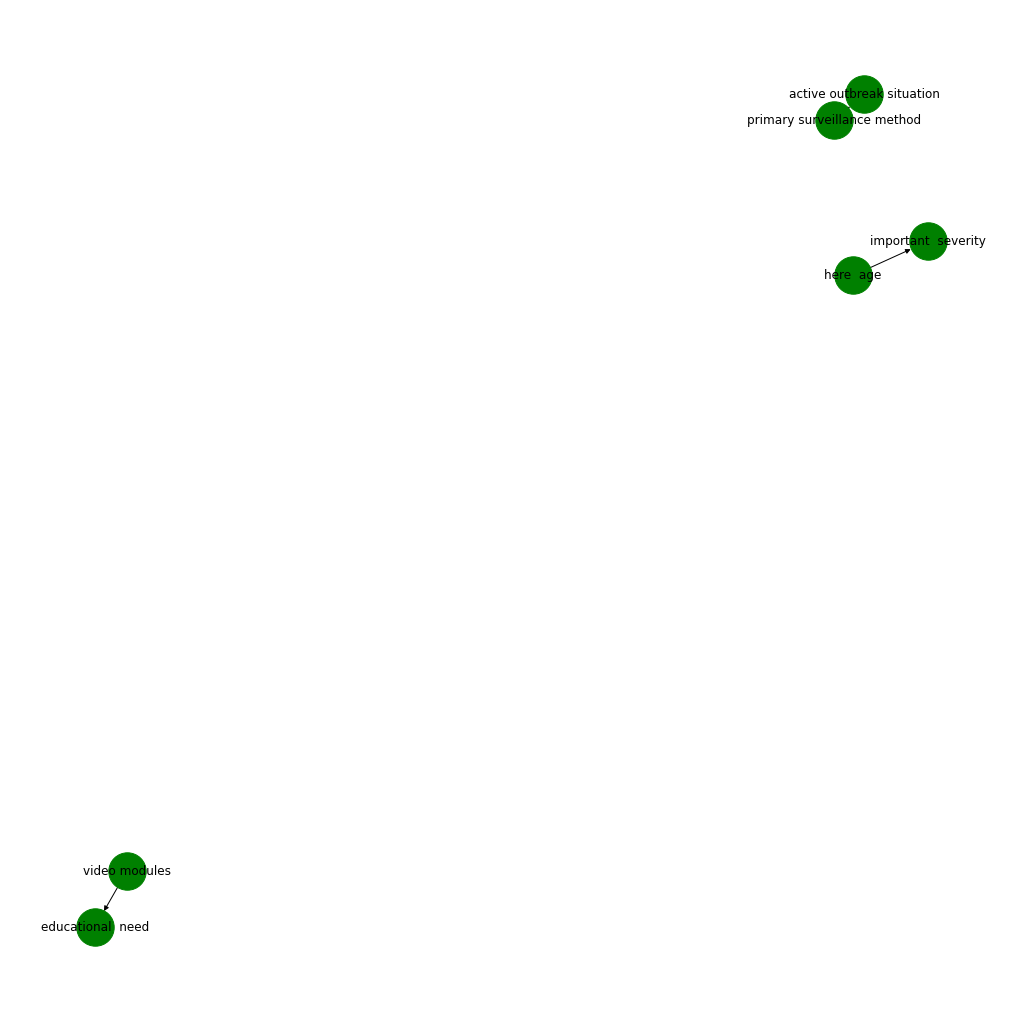

In [13]:
#From the above graph it’s unclear to get a sense of what 
#relations are captured in the graph
#Let’s use some relation to visualize graphs. Here I am choosing:

graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="conclude"], "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())
 
plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()